In [1]:
import tensorflow as tf
from tensorflow import keras

import IPython

In [2]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 5.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=2b5ff19a6592a5ae15c3e5c75af9ace2fcb24d57d33faab4ac1a18da31f4d56e
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=b6c8a12b0ab05bb9c709ad958951892d326c785a38c7fb3f1ba66137d65cc63b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
import kerastuner as kt

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [6]:
len(img_train), len(img_test)

(60000, 10000)

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

In [10]:
tuner = kt.Hyperband(model_builder,
                      objective='val_accuracy',
                      max_epochs= 10,
                      factor=3,
                      directory='my_dir',
                      project_name='theFirstKT')

In [11]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)   

In [12]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 48s]
val_accuracy: 0.8529999852180481

Best val_accuracy So Far: 0.8871999979019165
Total elapsed time: 00h 09m 52s
INFO:tensorflow:Oracle triggered exit


In [13]:
best_hps

In [14]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 448)               351680    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                4490      
Total params: 356,170
Trainable params: 356,170
Non-trainable params: 0
_________________________________________________________________


In [18]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5985 - accuracy: 0.7871 - val_loss: 0.4376 - val_accuracy: 0.8426
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3694 - accuracy: 0.8658 - val_loss: 0.3995 - val_accuracy: 0.8537
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3263 - accuracy: 0.8799 - val_loss: 0.3882 - val_accuracy: 0.8607
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2998 - accuracy: 0.8878 - val_loss: 0.3550 - val_accuracy: 0.8704
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2795 - accuracy: 0.8953 - val_loss: 0.3449 - val_accuracy: 0.8748
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2676 - accuracy: 0.8991 - val_loss: 0.3577 - val_accuracy: 0.8743
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2483 - accuracy: 0.9062 - val_loss: 0.3739 - val_accuracy:

In [21]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

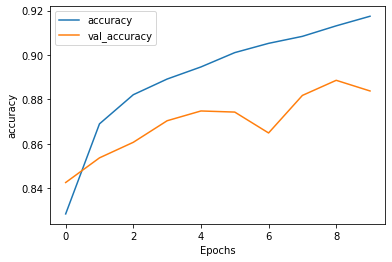

In [22]:
plot_graphs(history, 'accuracy')

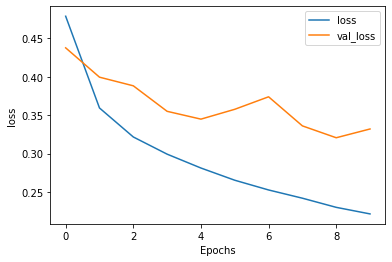

In [23]:
plot_graphs(history, 'loss')